In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers
import random
import tensorflow_probability as tfp



# Dataset

In [13]:
from keras.datasets import mnist

image_size = [28, 28]

def load_and_preprocess_mnist():
    (x_train, _), (x_test, _) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.

    # учитываем канал цвета. Ч/б -> 1
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

    return x_train, x_test

x_train, x_test = load_and_preprocess_mnist()

# Model

In [14]:
#для генерации слоучайных выборок из распределения данных (=семплирование)
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        #размер батча на основе размерности тензора z_mean
        batch = tf.shape(z_mean)[0]
        #размерность скрытого пространства
        dim = tf.shape(z_mean)[1]
        #для введения шума в процесс сэмплирования
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        #формула для сэмплирования использует технику репараметризации для стабильного обучения
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [15]:
def corr_loss(z):
    coor_matrix = tfp.stats.correlation(z)
    loss = 0
    n,m = coor_matrix.shape
    for i in range(n):
        for j in range(m):
            if i!=j:
                loss+=coor_matrix[i,j]**2
    return loss

In [16]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        
    def call(self,x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return z,reconstruction

    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            #coorelation_loss = corr_loss(z)
            
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [17]:
from keras import backend as K
class VAE_GAN(keras.Model):    

    def __init__(self, vae, discriminator, opti1=keras.optimizers.Adam(), opti2=keras.optimizers.Adam(), opti3=keras.optimizers.Adam(), **kwargs):
        super(VAE_GAN, self).__init__(**kwargs)
        
        self.encoder = vae.encoder
        self.decoder = vae.decoder
        self.discriminator = discriminator
        self.vae = vae
        
        self.vae_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.correlation_loss_tracker = keras.metrics.Mean(name="cr_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="disc_loss")
        self.gen_loss_tracker = keras.metrics.Mean(name="gen_loss")
        self.disc_loss = keras.losses.BinaryCrossentropy()
        
        self.vae_optimizer = opti1
        self.gen_optimizer = opti2
        self.disc_optimizer = opti3
        
    # прямой проход    
    def call(self,x):
        # z - вектор из латентного распределения
        z_mean, z_log_var, z = self.encoder(x)
        # генерация изображения на основе латентного распределения
        reconstruction = self.decoder(z)
        return z,reconstruction

    @property
    def metrics(self):
        return [
            self.vae_loss_tracker, # общая потеря модели
            self.reconstruction_loss_tracker, # потеря восстановления
            self.kl_loss_tracker, #потеря дивергенции Кульбака-Лейблера
            self.correlation_loss_tracker, #потеря корреляции (регуляризация?)
            self.disc_loss_tracker, #потеря дискриминатора
            self.gen_loss_tracker #потеря генератора
        ]

    def train_step(self, data):        
        batch_size = K.shape(data)[0]    
        
        with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:
            # Прямой проход через кодировщик и декодировщик
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Считаем потери
            reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            coorelation_loss = corr_loss(z)
            
            
            # GAN
            # Генерируем данные
            recon_vect = z 
            contruction = self.decoder(recon_vect)
            
            # Комбинируем оригинальные данные со сгенерированными
            combined_images = tf.concat([data, contruction], axis=0)
            # Создаем метки для дискриминатора. 0 - реальные данные, 1 - сгенерированные
            data_l,recon_l = tf.zeros((batch_size, 1)),tf.ones((batch_size, 1))
            combined_l = tf.concat([data_l, recon_l], axis=0)
            # Получаем предсказания от дискриминатора
            tot_predictions = self.discriminator(combined_images)
            r_prediction = self.discriminator(contruction)

            #Считаем потери дискриминатора и генератора
            discr_loss = self.disc_loss(combined_l,tot_predictions)
            gen_loss = tf.math.maximum(self.disc_loss(data_l,r_prediction) - discr_loss,.0001)
        
            #=========
            vae_loss = reconstruction_loss + kl_loss + gen_loss #+.1*coorelation_loss 

        # Cчитаем градиенты       
        grad_discr = disc_tape.gradient(discr_loss, self.discriminator.trainable_weights)
        grad_vae = enc_tape.gradient(vae_loss, self.vae.trainable_weights)
        
        # Применение градиентов для обновления весов дискриминатора и вариационного автоэнкодера с использованием соответствующих оптимизаторов
        self.disc_optimizer.apply_gradients(zip(grad_discr, self.discriminator.trainable_weights))
        self.vae_optimizer.apply_gradients(zip(grad_vae, self.vae.trainable_weights))

        # Обновление метрик с использованием вычисленных значений потерь.                                   
        self.vae_loss_tracker.update_state(vae_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.correlation_loss_tracker.update_state(coorelation_loss)
        self.disc_loss_tracker.update_state(discr_loss)
        self.gen_loss_tracker.update_state(gen_loss)
        
        return {
            "vae_loss": self.vae_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result(),
            "gen_los": self.gen_loss_tracker.result(),
        }

In [19]:
lrelu = tf.nn.selu

latent_dim = 32 # количество нейроновой в латентном пространстве 
a,b = image_size
shape=(a, b, 1)

# определяет входы для кодировщика
encoder_inputs = keras.Input(shape=shape)
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 512)          401920      ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          131328      ['dense[0][0]']                  
                                                                                            

In [20]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation='relu')(latent_inputs)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(np.prod(shape), activation='sigmoid')(x)
decoder_outputs = layers.Reshape(shape)(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_2 (Dense)             (None, 256)               8448      
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 dense_4 (Dense)             (None, 784)               402192    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 542,224
Trainable params: 542,224
Non-trainable params: 0
_________________________________________________________________


In [21]:
discriminator_inputs = keras.Input(shape=shape)

x = layers.Conv2D(128, 8, activation="relu", strides=2, padding="same")(discriminator_inputs)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 5, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
discriminator_outputs = layers.Dense(1,activation="sigmoid")(x)
discriminator = keras.Model(discriminator_inputs, discriminator_outputs, name="discriminator")
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       8320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 128)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 64)       

# Training

In [23]:
epochs = 10
batch_size = 128

vae = VAE(encoder,decoder)
model = VAE_GAN(vae, discriminator)
model.compile(optimizer=keras.optimizers.Adam())

In [26]:
import matplotlib.pyplot as plt

def generate_images(model, n_images, latent_dim):
    random_latent_vectors = tf.random.normal(shape=(n_images, latent_dim))
    generated_images = model.predict(random_latent_vectors)
    return generated_images

def plot_images(images, n_rows, n_cols, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


<Axes: >

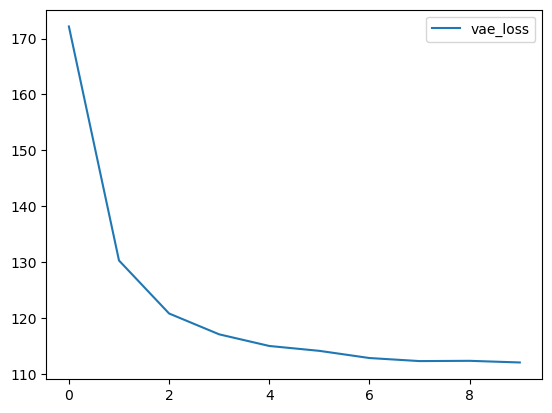

In [57]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['vae_loss']].plot()

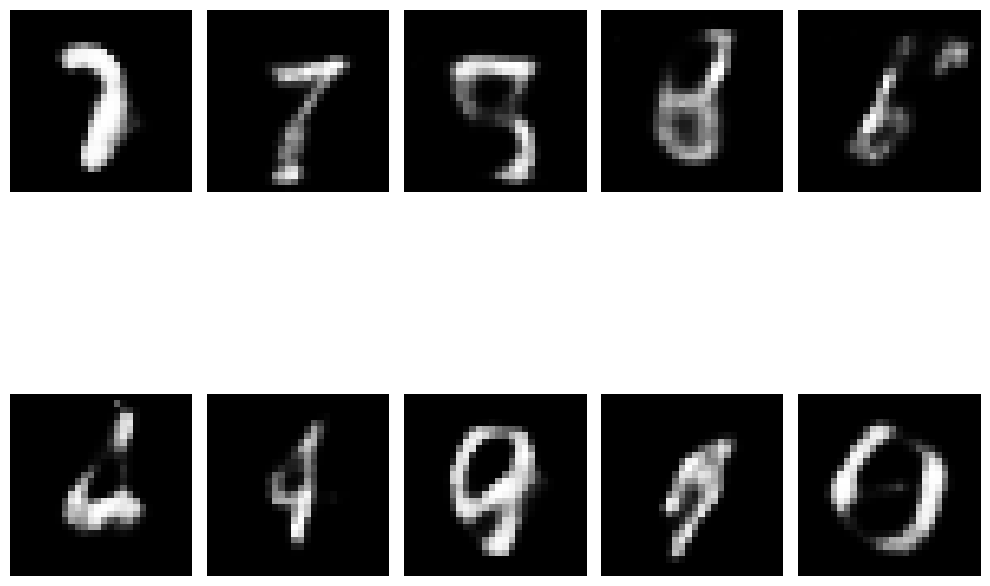

In [58]:
# Epochs = 10

Epoch 1/100
469/469 [==============================] - 37s 78ms/step - vae_loss: 111.8879 - disc_loss: 0.0386 - gen_los: 7.6502 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_cr_loss: 0.0000e+00 - val_disc_loss: 0.0000e+00 - val_gen_loss: 0.0000e+00
Epoch 2/100
469/469 [==============================] - 36s 77ms/step - vae_loss: 111.9138 - disc_loss: 0.0348 - gen_los: 8.0041 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_cr_loss: 0.0000e+00 - val_disc_loss: 0.0000e+00 - val_gen_loss: 0.0000e+00
Epoch 3/100
469/469 [==============================] - 37s 78ms/step - vae_loss: 111.0946 - disc_loss: 0.0300 - gen_los: 7.8621 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_cr_loss: 0.0000e+00 - val_disc_loss: 0.0000e+00 - val_gen_loss: 0.0000e+00
Epoch 4/100
469/469 [==============================] - 37s 78ms/step - vae_loss: 111.8015 - di

<Axes: >

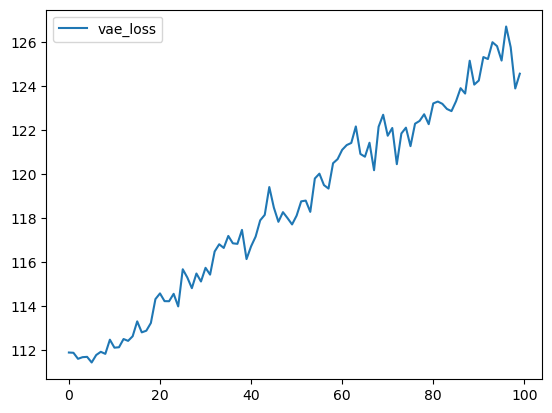

In [59]:
history = model.fit(x_train, epochs=100, batch_size=batch_size, validation_data=(x_test, x_test), verbose = 1)

n_images = 10
generated_images = generate_images(decoder, n_images, latent_dim)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['vae_loss']].plot()

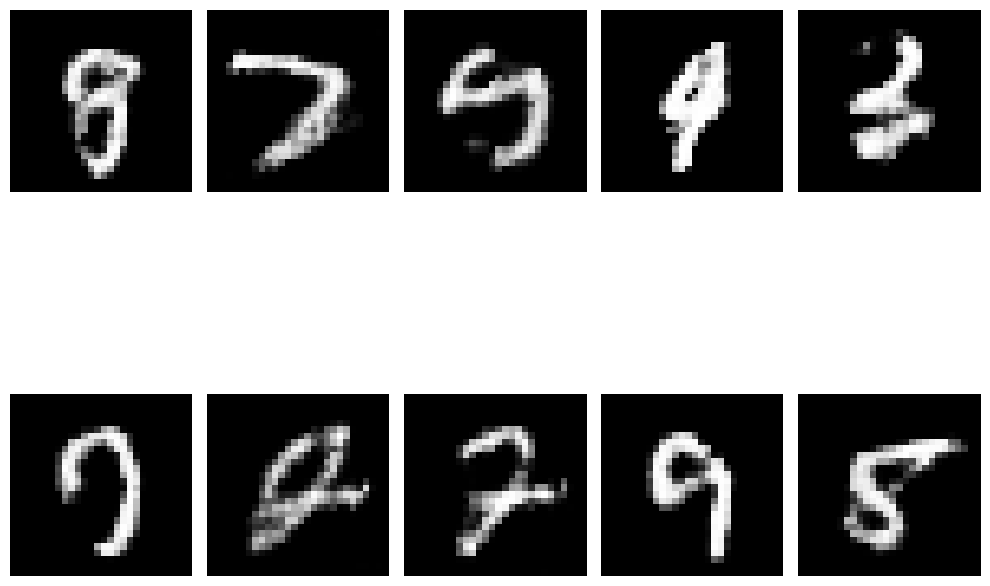

In [60]:
n_rows, n_cols = 2, 5 
plot_images(generated_images, n_rows, n_cols)

In [24]:
history = model.fit(x_train, epochs=200, batch_size=batch_size, validation_data=(x_test, x_test), verbose = 1)

n_images = 10
generated_images = generate_images(decoder, n_images, latent_dim)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['vae_loss']].plot()

Epoch 1/200
469/469 [==============================] - 46s 90ms/step - vae_loss: 181.6703 - disc_loss: 0.0215 - gen_los: 10.0714 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_cr_loss: 0.0000e+00 - val_disc_loss: 0.0000e+00 - val_gen_loss: 0.0000e+00
Epoch 2/200
469/469 [==============================] - 37s 80ms/step - vae_loss: 133.4306 - disc_loss: 0.0388 - gen_los: 8.6455 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_cr_loss: 0.0000e+00 - val_disc_loss: 0.0000e+00 - val_gen_loss: 0.0000e+00
Epoch 3/200
469/469 [==============================] - 35s 75ms/step - vae_loss: 122.8757 - disc_loss: 0.0679 - gen_los: 7.3750 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_cr_loss: 0.0000e+00 - val_disc_loss: 0.0000e+00 - val_gen_loss: 0.0000e+00
Epoch 4/200
469/469 [==============================] - 35s 74ms/step - vae_loss: 119.0490 - d

NameError: name 'generate_images' is not defined

1/1 [==============================] - 0s 10ms/step


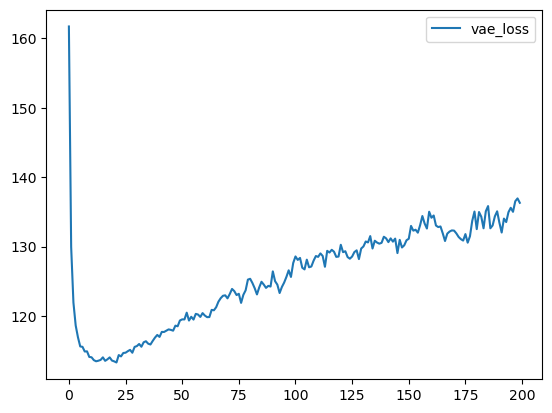

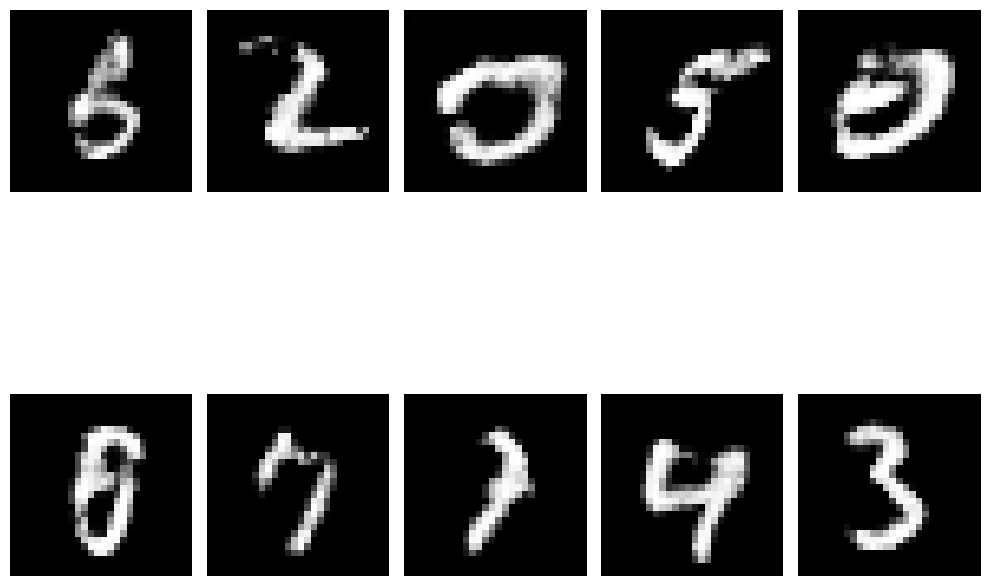

In [28]:
n_images = 10
generated_images = generate_images(decoder, n_images, latent_dim)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['vae_loss']].plot()

n_rows, n_cols = 2, 5 
plot_images(generated_images, n_rows, n_cols)